In [ ]:
! pip install pandas
! pip install openpyxl
! pip install matplotlib
! pip install numpy
! pip install seaborn
! pip install missingno

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import datetime as dt

In [ ]:

# Specify the file path
file_path1 = "D:\\Guvi projects\\Birds species Obz project data\\Bird_Monitoring_Data_GRASSLAND.xlsx"
file_path2 = "D:\\Guvi projects\\Birds species Obz project data\\Bird_Monitoring_Data_FOREST.xlsx"

# Read the Excel file with multiple sheets
excel_data1 = pd.ExcelFile(file_path1)
excel_data2 = pd.ExcelFile(file_path2)

# Get all sheet names
sheet_names1 = excel_data1.sheet_names
sheet_names2 = excel_data2.sheet_names
# print(sheet_names)

# Read data from all sheets into a dictionary
sheets_dict1 = {sheet: excel_data1.parse(sheet) for sheet in sheet_names1}
sheets_dict2 = {sheet: excel_data2.parse(sheet) for sheet in sheet_names2}
# print(sheets_dict)

all_sheets = []
for name, sheet in sheets_dict1.items():
    sheet['sheet'] = name
    sheet = sheet.rename(columns=lambda x: x.split('\n')[-1])
    all_sheets.append(sheet)

for name, sheet in sheets_dict2.items():
    sheet['sheet'] = name
    sheet = sheet.rename(columns=lambda x: x.split('\n')[-1])
    all_sheets.append(sheet)

full_table = pd.concat(all_sheets)
full_table.reset_index(inplace=True, drop=True)

full_table_master = full_table

full_table_master

In [3]:
# Blank distance considered as bird doesn't exist in the place.
full_table.dropna(subset=['Distance'], inplace=True)
full_table.fillna("Undetermined", axis=1, inplace=True)

In [ ]:
# full_table.drop(columns=['Sub_Unit_Code', 'AcceptedTSN', 'TaxonCode', 'Previously_Obs', 'Initial_Three_Min_Cnt', 'NPSTaxonCode', 'Site_Name','sheet'], inplace=True)

full_table.drop(columns=['sheet'], inplace=True)
full_table

In [ ]:
missing_value_counts=full_table.isnull().sum()
missing_value_counts

In [ ]:
full_table['Interval_Length'] = full_table['Interval_Length'].str.replace("min", "")
Start_end_interval = full_table['Interval_Length'].str.split("-", expand = True)

Start_end_interval.head()

full_table['Start_Interval'] = Start_end_interval[0].astype('float')
full_table['End_Interval'] = Start_end_interval[1].astype('float')


full_table.drop(columns=['Interval_Length'], inplace=True)
full_table.head()

In [ ]:
full_table.head()
full_table

In [8]:
mappings = {'<= 50 Meters':'Closer','50 - 100 Meters':'Farther'}
full_table['Distance']= full_table['Distance'].replace(mappings)

In [9]:
full_table.drop_duplicates()
full_table.shape

(15591, 32)

In [ ]:
full_table.dtypes

In [ ]:
full_table['Year']=full_table['Year'].astype('int')
full_table.dtypes

In [ ]:
full_table['Date']=pd.to_datetime(full_table['Date'],format='%y-%m-%d')
full_table.dtypes

In [ ]:
full_table[['Temperature','Humidity']]=full_table[['Temperature','Humidity']].astype('float')
full_table['Visit']=full_table['Visit'].astype('int')

full_table.dtypes

In [ ]:
full_table[['PIF_Watchlist_Status','Regional_Stewardship_Status','Flyover_Observed']]=full_table[['PIF_Watchlist_Status','Regional_Stewardship_Status','Flyover_Observed']].astype('boolean')
full_table.dtypes
# full_table.shape

In [3]:
import pymysql

connection = pymysql.connect(
    host = "localhost",
    user = "root",
    password = "",
    database="birds_db"

)

mycursor = connection.cursor()

In [ ]:
# CREATE TABLE
'''mycursor.execute("create table bird_monitoring(Admin_Unit_Code Varchar(255), Plot_Name Varchar(255), Location_Type Varchar(255), Year Int(4), Date Date, Start_Time Time, End_Time Time, Observer  Varchar(255), Visit Int(2), ID_Method Varchar(255), Distance Varchar(255), Flyover_Observed boolean, Sex Varchar(255), Common_Name Varchar(255), Scientific_Name Varchar(255), AOU_Code Varchar(255), PIF_Watchlist_Status boolean, Regional_Stewardship_Status boolean, Temperature float, Humidity float, Sky Varchar(255), Wind  Varchar(255), Disturbance  Varchar(255), Start_Interval float, End_Interval float)")'''

0

In [ ]:
# INSERT DATA
'''birds_query="""
insert into bird_monitoring (Admin_Unit_Code,Plot_Name,Location_Type,Year,Date,Start_Time,End_Time,Observer,Visit,ID_Method,	Distance,Flyover_Observed,Sex,Common_Name,Scientific_Name,AOU_Code,PIF_Watchlist_Status,Regional_Stewardship_Status,Temperature, Humidity, Sky, Wind, Disturbance, Start_Interval, End_Interval) values (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
"""

birds_data = full_table[['Admin_Unit_Code','Plot_Name','Location_Type','Year','Date','Start_Time','End_Time','Observer','Visit','ID_Method','Distance','Flyover_Observed','Sex','Common_Name','Scientific_Name','AOU_Code','PIF_Watchlist_Status','Regional_Stewardship_Status','Temperature','Humidity','Sky','Wind','Disturbance','Start_Interval','End_Interval']].values.tolist()

mycursor.executemany(birds_query, birds_data)
connection.commit()'''

In [51]:
mycursor.close()
connection.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\3148545059.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  season_full_table = pd.read_sql(season_query, connection)


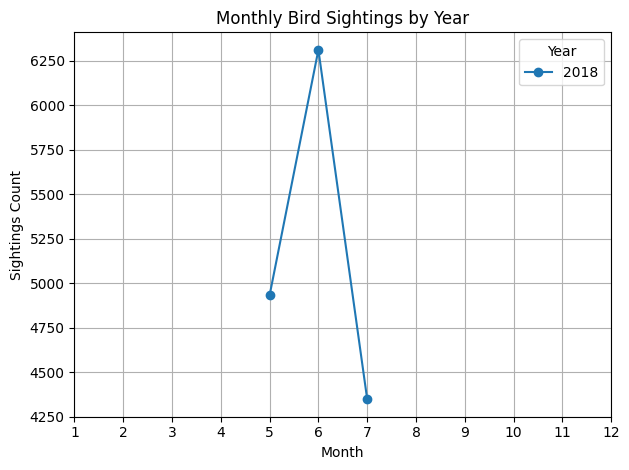

In [4]:
# 1.Temporal Analysis

# Seasonal Visualization
import pandas as pd
import matplotlib.pyplot as plt

season_query = """
SELECT 
    YEAR(Date) AS Year,
    MONTH(Date) AS Month,
    COUNT(*) AS Sightings
FROM bird_monitoring
WHERE Date IS NOT NULL
GROUP BY Year, Month
ORDER BY Year, Month;
"""

season_full_table = pd.read_sql(season_query, connection)

# Pivot to show trends by year
pivot = season_full_table.pivot(index='Month', columns='Year', values='Sightings')
pivot.plot(kind='line', marker='o')
plt.title('Monthly Bird Sightings by Year')
plt.xlabel('Month')
plt.ylabel('Sightings Count')
plt.xticks(range(1,13))
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\3925239130.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_full_table = pd.read_sql(time_query, connection)


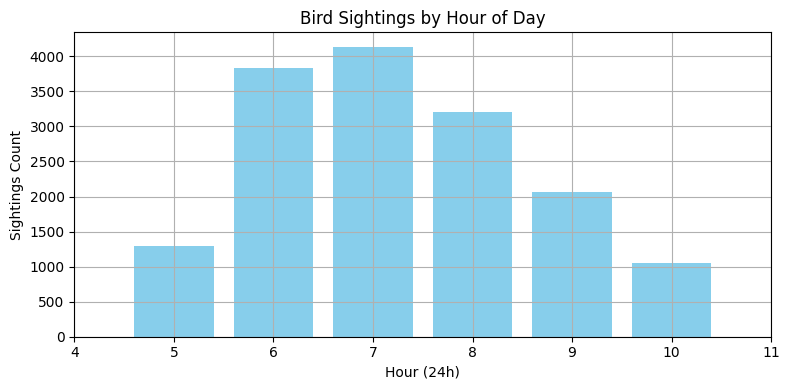

In [5]:
# Observation Time of Day Trends
time_query = """
SELECT 
    HOUR(Start_Time) AS Hour,
    COUNT(*) AS Sightings
FROM bird_monitoring
WHERE Start_Time IS NOT NULL
GROUP BY HOUR(Start_Time)
ORDER BY Hour;
"""

time_full_table = pd.read_sql(time_query, connection)

# Plot hourly bird activity
plt.figure(figsize=(8,4))
plt.bar(time_full_table['Hour'], time_full_table['Sightings'], color='skyblue')
plt.title('Bird Sightings by Hour of Day')
plt.xlabel('Hour (24h)')
plt.ylabel('Sightings Count')
plt.xticks(range(4, 12))  # Typical bird survey window
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\3529523836.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  location_full_table = pd.read_sql(location_query, connection)


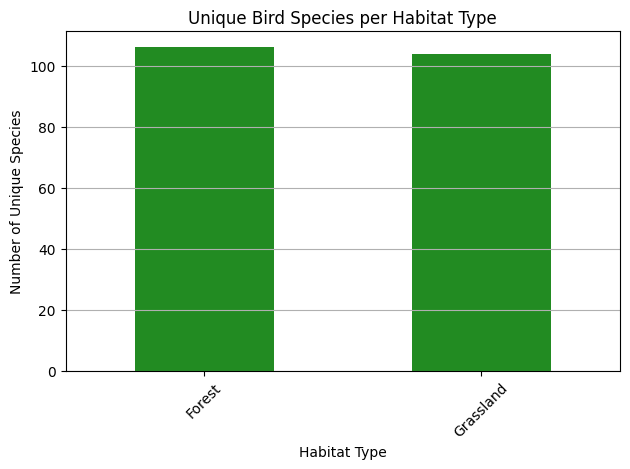

In [6]:
# 2. Spatial Analysis

# Location Insights:

location_query = """
SELECT 
    Location_Type,
    COUNT(*) AS Total_Observations,
    COUNT(DISTINCT Scientific_Name) AS Unique_Species
FROM bird_monitoring
WHERE Scientific_Name IS NOT NULL
GROUP BY Location_Type
ORDER BY Unique_Species DESC;
"""

location_full_table = pd.read_sql(location_query, connection)

# Plot unique species by habitat
location_full_table.plot(x='Location_Type', y='Unique_Species', kind='bar', legend=False, color='forestgreen')
plt.title('Unique Bird Species per Habitat Type')
plt.xlabel('Habitat Type')
plt.ylabel('Number of Unique Species')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\1230397784.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  plot_full_table = pd.read_sql(plot_query, connection)


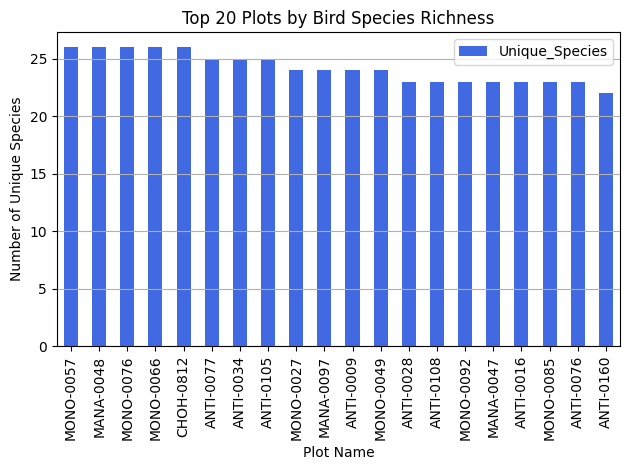

In [7]:
# Plot-Level Analysis:

plot_query = """
SELECT 
    Plot_Name,
    COUNT(*) AS Total_Observations,
    COUNT(DISTINCT Scientific_Name) AS Unique_Species
FROM bird_monitoring
WHERE Scientific_Name IS NOT NULL
GROUP BY Plot_Name
ORDER BY Unique_Species DESC
LIMIT 20;
"""

plot_full_table = pd.read_sql(plot_query, connection)

# Plot top plots by unique species
plot_full_table.plot(x='Plot_Name', y='Unique_Species', kind='bar', color='royalblue')
plt.title('Top 20 Plots by Bird Species Richness')
plt.xlabel('Plot Name')
plt.ylabel('Number of Unique Species')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10160\219921963.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  diversity_full_table = pd.read_sql(query, connection)


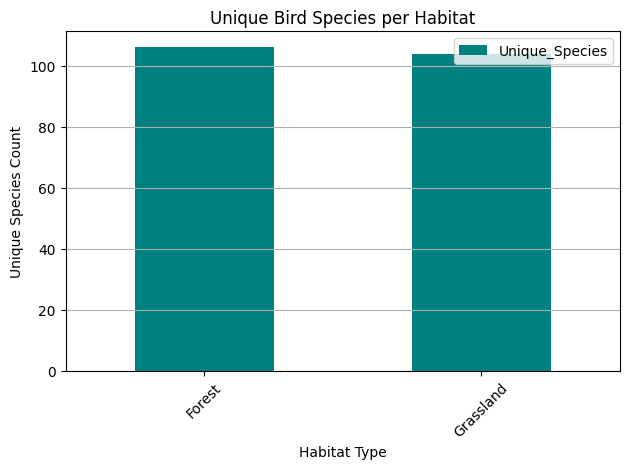

In [9]:
# 3. Species Analysis

# Diversity Metrics - Count unique species and their spread across habitats.

query = """
SELECT Location_Type, COUNT(DISTINCT Scientific_Name) AS Unique_Species
FROM bird_monitoring
WHERE Scientific_Name IS NOT NULL
GROUP BY Location_Type
ORDER BY Unique_Species DESC;
"""
diversity_full_table = pd.read_sql(query, connection)

diversity_full_table.plot(x='Location_Type', y='Unique_Species', kind='bar', color='teal')
plt.title("Unique Bird Species per Habitat")
plt.xlabel("Habitat Type")
plt.ylabel("Unique Species Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\3989979106.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  activity_full_table = pd.read_sql(query, connection)


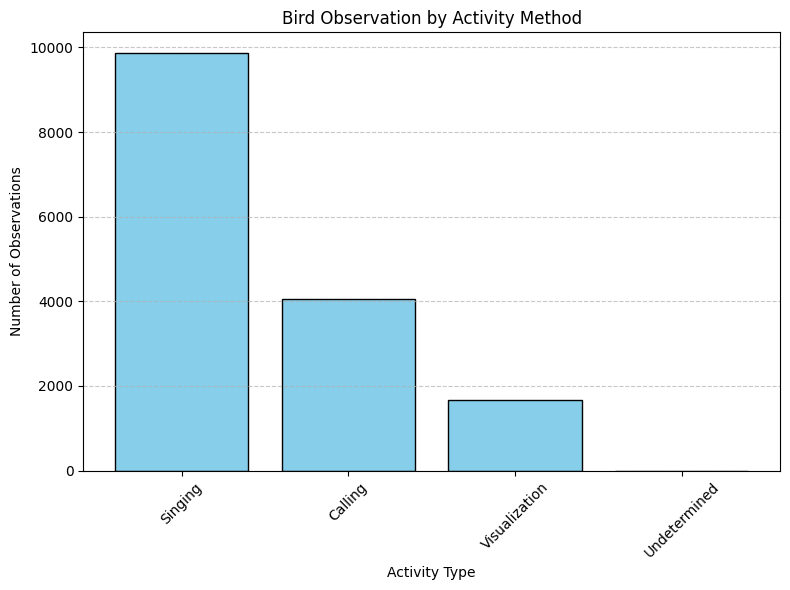

In [8]:
# 2. Activity Patterns

# 2. Query activity method counts
query = """
SELECT 
    ID_Method,
    COUNT(*) AS Observation_Count
FROM bird_monitoring
WHERE ID_Method IS NOT NULL AND ID_Method != ''
GROUP BY ID_Method
ORDER BY Observation_Count DESC;
"""

activity_full_table = pd.read_sql(query, connection)

# 3. Plot activity types
plt.figure(figsize=(8, 6))
plt.bar(activity_full_table['ID_Method'], activity_full_table['Observation_Count'], color='skyblue', edgecolor='black')
plt.title('Bird Observation by Activity Method')
plt.xlabel('Activity Type')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\3586078540.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sex_location_full_table = pd.read_sql(query_location, connection)


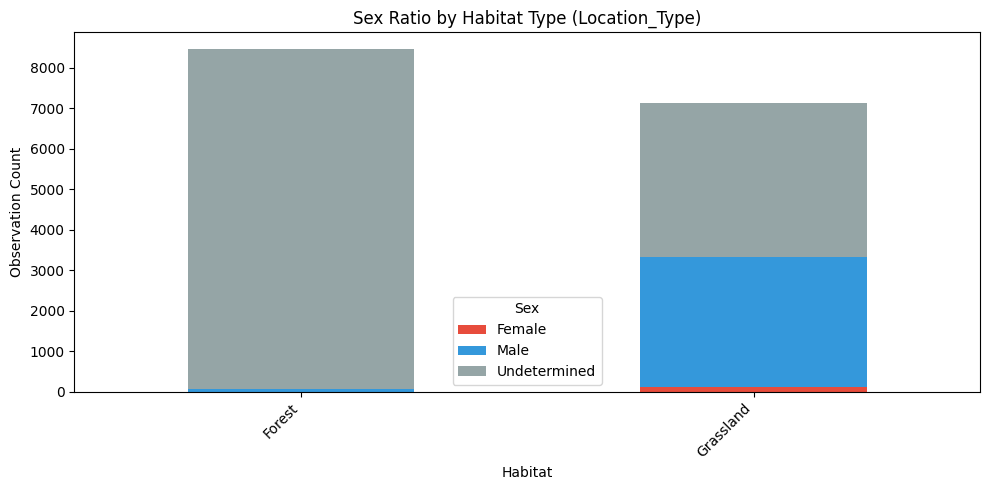

In [9]:
# Sex Ratio : Determine male/female/undetermined counts for each species.

# Query to get sex counts per location type
query_location = """
SELECT 
    Location_Type,
    Sex,
    COUNT(*) AS Count
FROM bird_monitoring
WHERE Sex IS NOT NULL AND Sex != ''
GROUP BY Location_Type, Sex;
"""

sex_location_full_table = pd.read_sql(query_location, connection)

# Pivot for plotting
pivot_location = sex_location_full_table.pivot(index='Location_Type', columns='Sex', values='Count').fillna(0)

# Plot
pivot_location.plot(kind='bar', stacked=True, figsize=(10, 5),
                    color={'Male': '#3498db', 'Female': '#e74c3c', 'Undetermined': '#95a5a6'})
plt.title('Sex Ratio by Habitat Type (Location_Type)')
plt.xlabel('Habitat')
plt.ylabel('Observation Count')
plt.legend(title='Sex')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\2747526869.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sex_species_full_table = pd.read_sql(query_species, connection)


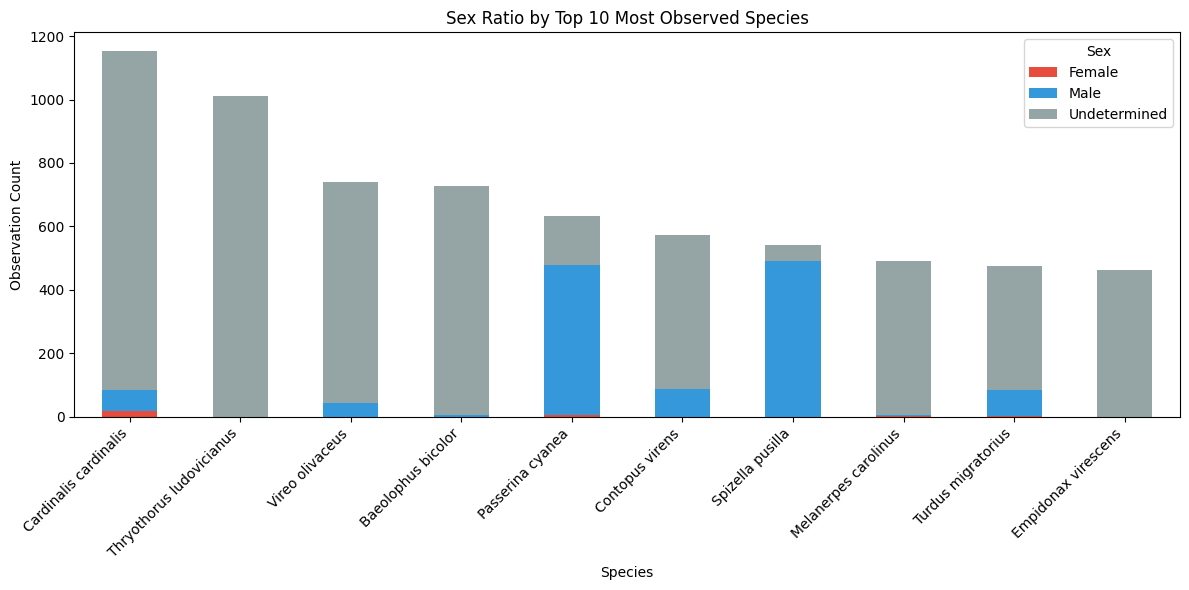

In [10]:
# Query to get sex counts per species
query_species = """
SELECT 
    Scientific_Name,
    Sex,
    COUNT(*) AS Count
FROM bird_monitoring
WHERE Sex IS NOT NULL AND Sex != ''
GROUP BY Scientific_Name, Sex;
"""

sex_species_full_table = pd.read_sql(query_species, connection)

# Pivot to wide format
pivot_species = sex_species_full_table.pivot(index='Scientific_Name', columns='Sex', values='Count').fillna(0)

# Select top 10 species by total count
pivot_species['Total'] = pivot_species.sum(axis=1)
top_species = pivot_species.sort_values('Total', ascending=False).head(10)

# Drop 'Total' column for plotting
top_species.drop(columns='Total').plot(kind='bar', stacked=True, figsize=(12, 6),
                                       color={'Male': '#3498db', 'Female': '#e74c3c', 'Undetermined': '#95a5a6'})
plt.title('Sex Ratio by Top 10 Most Observed Species')
plt.xlabel('Species')
plt.ylabel('Observation Count')
plt.legend(title='Sex')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\925953385.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  full_table = pd.read_sql("SELECT * FROM bird_monitoring", connection)


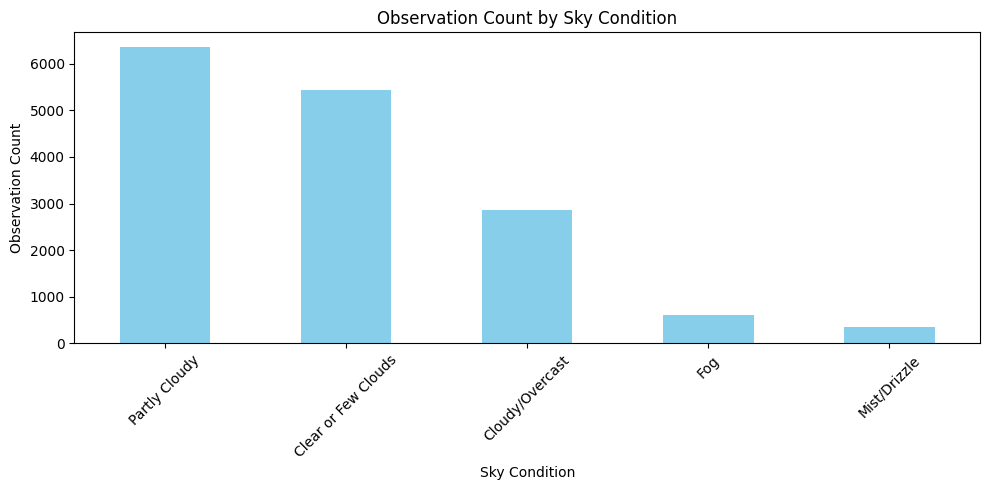

In [11]:
#  Environmental Conditions

full_table = pd.read_sql("SELECT * FROM bird_monitoring", connection)

# Convert Temperature and Humidity to numeric
full_table['Temperature'] = pd.to_numeric(full_table['Temperature'], errors='coerce')
full_table['Humidity'] = pd.to_numeric(full_table['Humidity'], errors='coerce')

# Filter valid environmental rows
env_full_table = full_table.dropna(subset=['Temperature', 'Humidity', 'Sky', 'Wind', 'Disturbance'])

# Add a count column for summary
env_full_table['Observation'] = 1

# Group by Sky condition
sky_summary = env_full_table.groupby('Sky')['Observation'].count().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sky_summary.plot(kind='bar', color='skyblue')
plt.title('Observation Count by Sky Condition')
plt.ylabel('Observation Count')
plt.xlabel('Sky Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\2132818889.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  full_table = pd.read_sql("SELECT * FROM bird_monitoring", connection)  # if using SQL
C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\2132818889.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disturbance_summary.index, y=disturbance_summary.values, palette='viridis')


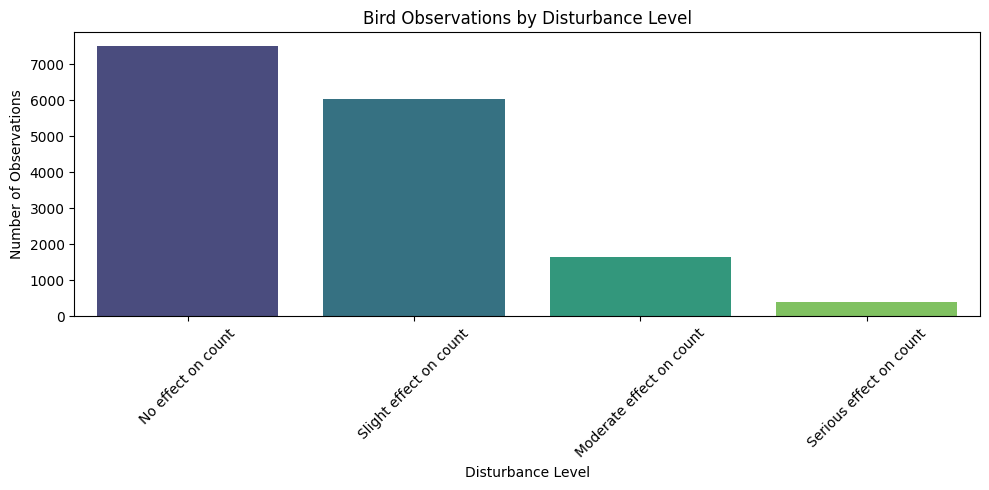

In [20]:

full_table = pd.read_sql("SELECT * FROM bird_monitoring", connection)  # if using SQL

# Add a count column
full_table['Observation'] = 1

# Group by Disturbance and count observations
disturbance_summary = full_table.groupby('Disturbance')['Observation'].sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(x=disturbance_summary.index, y=disturbance_summary.values, palette='viridis')
plt.title('Bird Observations by Disturbance Level')
plt.xlabel('Disturbance Level')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


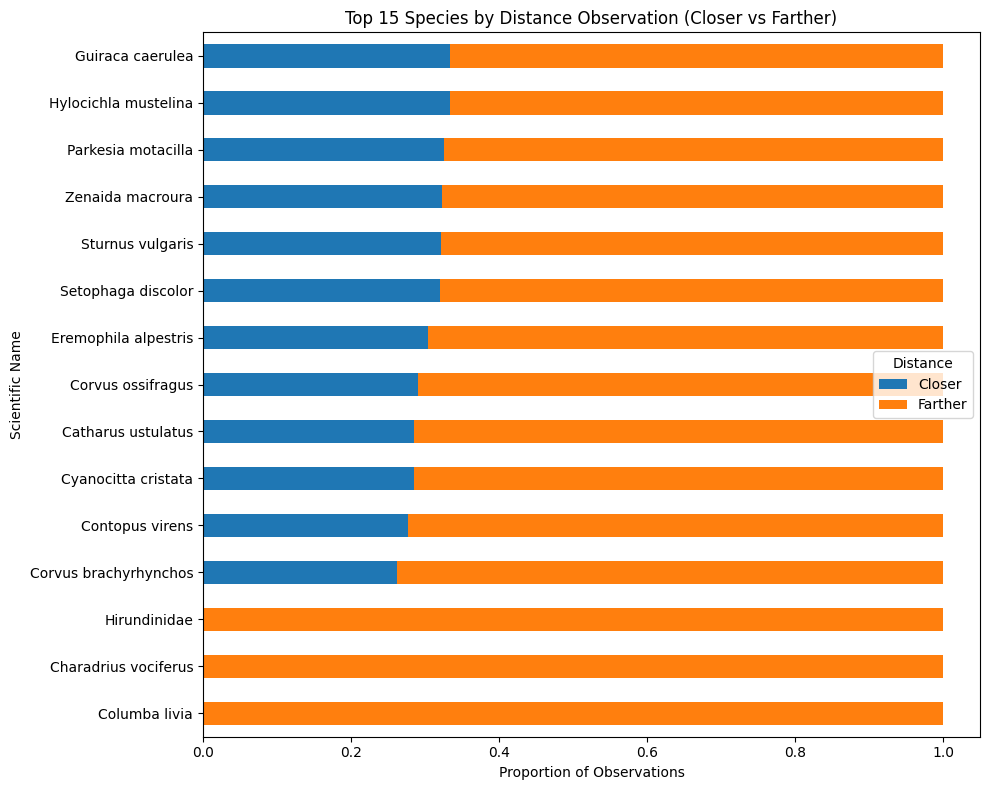

In [13]:
# # 5. Distance and Behavior

# Filter only relevant rows
distance_full_table = full_table[full_table['Distance'].isin(['Closer', 'Farther'])]

# Group by species and distance
species_distance = (
    distance_full_table.groupby(['Scientific_Name', 'Distance'])
    .size()
    .unstack(fill_value=0)
)

# Optional: Filter to only species with enough observations
species_distance = species_distance[species_distance.sum(axis=1) >= 10]

# Normalize for proportion (row-wise)
species_distance_prop = species_distance.div(species_distance.sum(axis=1), axis=0)

# Plot
species_distance_prop.sort_values("Farther", ascending=False).head(15).plot(
    kind='barh',
    stacked=True,
    color=['#1f77b4', '#ff7f0e'],
    figsize=(10, 8)
)
plt.title("Top 15 Species by Distance Observation (Closer vs Farther)")
plt.xlabel("Proportion of Observations")
plt.ylabel("Scientific Name")
plt.legend(title="Distance")
plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\3816408746.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_species_per_observer = species_obs.groupby('Observer').apply(


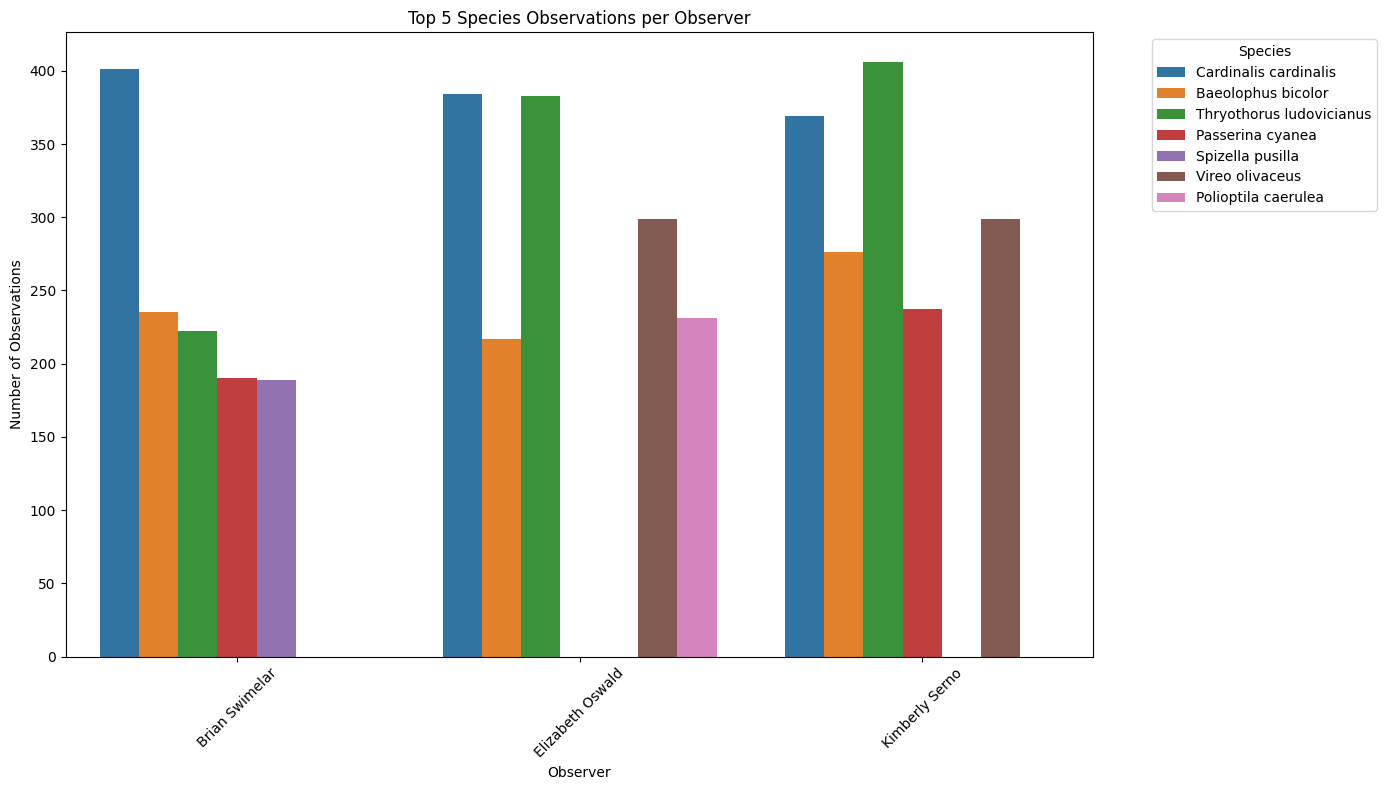

In [14]:
# 6. Observer Trends

# Count observations per Observer and Scientific_Name
species_obs = full_table.groupby(['Observer', 'Scientific_Name']).size().reset_index(name='Counts')

# Get top 5 species per observer by observation counts
top_species_per_observer = species_obs.groupby('Observer').apply(
    lambda x: x.nlargest(5, 'Counts')).reset_index(drop=True)

# Plot using seaborn's barplot grouped by observer with hue as species
plt.figure(figsize=(14,8))
sns.barplot(data=top_species_per_observer, x='Observer', y='Counts', hue='Scientific_Name')

plt.xticks(rotation=45)
plt.title('Top 5 Species Observations per Observer')
plt.ylabel('Number of Observations')
plt.xlabel('Observer')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


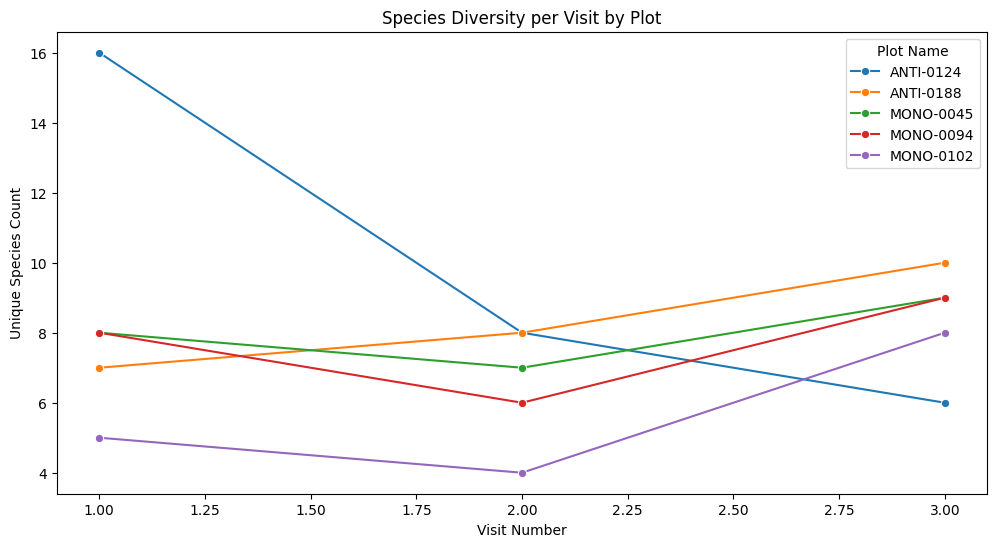

In [15]:
# Optional: filter for top plots if too many
top_plots = full_table['Plot_Name'].value_counts().nlargest(5).index
filtered_full_table = full_table[full_table['Plot_Name'].isin(top_plots)]

visit_plot_diversity = filtered_full_table.groupby(['Visit', 'Plot_Name'])['Scientific_Name'].nunique().reset_index(name='Unique_Species_Count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=visit_plot_diversity, x='Visit', y='Unique_Species_Count', hue='Plot_Name', marker='o')
plt.title('Species Diversity per Visit by Plot')
plt.xlabel('Visit Number')
plt.ylabel('Unique Species Count')
plt.legend(title='Plot Name')
plt.show()


   Visit  Unique_Species_Count  Total_Observations
0      1                   117                6912
1      2                    96                6509
2      3                    68                2170


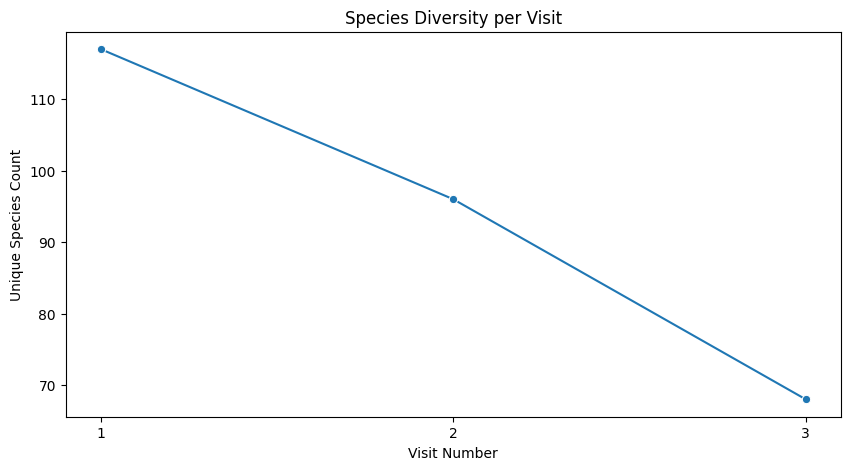

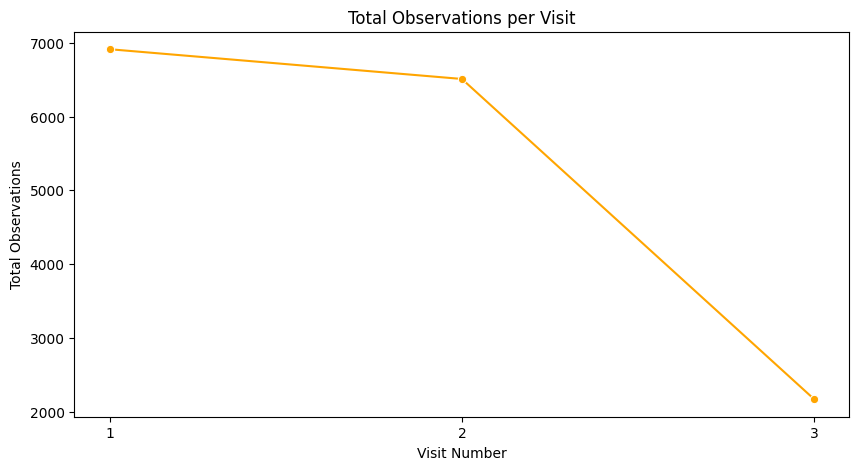

In [21]:


# Calculate number of unique species per Visit
species_diversity = full_table.groupby('Visit')['Scientific_Name'].nunique().reset_index(name='Unique_Species_Count')

# Calculate total number of observations per Visit
total_observations = full_table.groupby('Visit').size().reset_index(name='Total_Observations')

# Merge the two summaries
visit_summary = pd.merge(species_diversity, total_observations, on='Visit')

print(visit_summary.head())

# Plot Unique Species Count per Visit
plt.figure(figsize=(10,5))
sns.lineplot(data=visit_summary, x='Visit', y='Unique_Species_Count', marker='o')
plt.title('Species Diversity per Visit')
plt.xlabel('Visit Number')
plt.ylabel('Unique Species Count')
plt.xticks(visit_summary['Visit'].unique())
plt.show()

# Plot Total Observations per Visit
plt.figure(figsize=(10,5))
sns.lineplot(data=visit_summary, x='Visit', y='Total_Observations', marker='o', color='orange')
plt.title('Total Observations per Visit')
plt.xlabel('Visit Number')
plt.ylabel('Total Observations')
plt.xticks(visit_summary['Visit'].unique())
plt.show()


Columns in conservation_summary: Index(['Scientific_Name', 'PIF_Watchlist_Status',
       'Regional_Stewardship_Status', 'Common_Name', 'Watchlist',
       'Stewardship'],
      dtype='object')
         Scientific_Name        Watchlist      Stewardship
0     Accipiter cooperii  Not Watchlisted  Not Stewardship
1    Agelaius phoeniceus  Not Watchlisted  Not Stewardship
2             Aix sponsa  Not Watchlisted  Not Stewardship
3  Ammodramus savannarum  Not Watchlisted  Not Stewardship
4     Anas platyrhynchos  Not Watchlisted  Not Stewardship


C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\546602173.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=conservation_summary, x='Watchlist', palette='pastel')


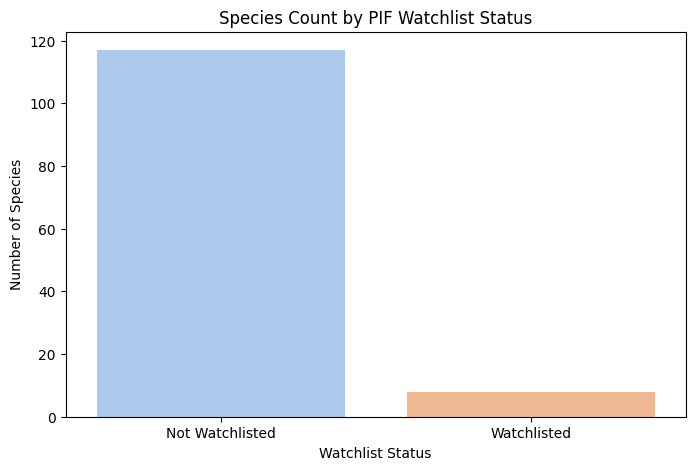

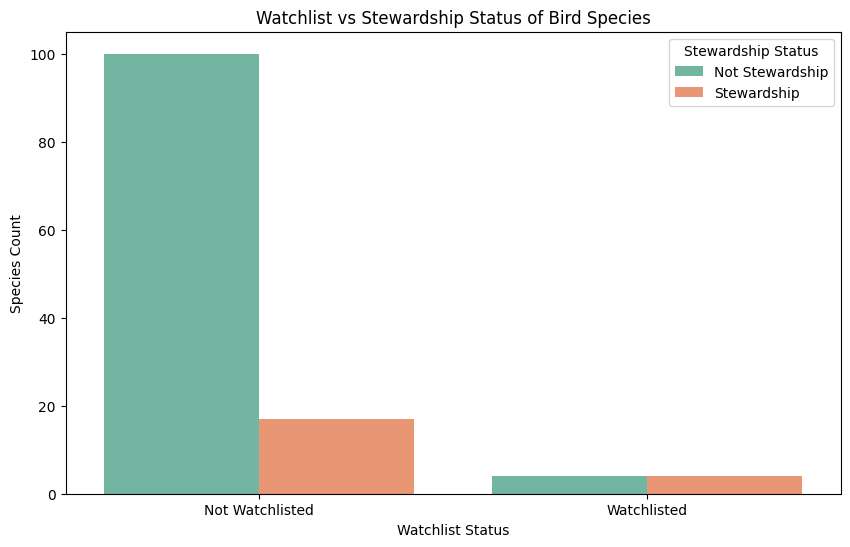

In [17]:
#7.Conservation Insights
#Watchlist Trends: Use the PIF_Watchlist_Status and Regional_Stewardship_Status to identify trends in species that are at risk or require conservation focus.

# Ensure the columns are numeric
full_table['PIF_Watchlist_Status'] = pd.to_numeric(full_table['PIF_Watchlist_Status'], errors='coerce')
full_table['Regional_Stewardship_Status'] = pd.to_numeric(full_table['Regional_Stewardship_Status'], errors='coerce')

# Group by species
conservation_summary = full_table.groupby('Scientific_Name').agg({
    'PIF_Watchlist_Status': 'max',  # if any record is 1, treat species as watchlisted
    'Regional_Stewardship_Status': 'max',
    'Common_Name': 'first'
}).reset_index()

# Add categorical labels
conservation_summary['Watchlist'] = conservation_summary['PIF_Watchlist_Status'].apply(
    lambda x: 'Watchlisted' if x == 1 else 'Not Watchlisted'
)
conservation_summary['Stewardship'] = conservation_summary['Regional_Stewardship_Status'].apply(
    lambda x: 'Stewardship' if x == 1 else 'Not Stewardship'
)

# ✅ Check columns exist
print("Columns in conservation_summary:", conservation_summary.columns)
print(conservation_summary[['Scientific_Name', 'Watchlist', 'Stewardship']].head())

plt.figure(figsize=(8, 5))
sns.countplot(data=conservation_summary, x='Watchlist', palette='pastel')
plt.title('Species Count by PIF Watchlist Status')
plt.xlabel('Watchlist Status')
plt.ylabel('Number of Species')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=conservation_summary, x='Watchlist', hue='Stewardship', palette='Set2')
plt.title('Watchlist vs Stewardship Status of Bird Species')
plt.xlabel('Watchlist Status')
plt.ylabel('Species Count')
plt.legend(title='Stewardship Status')
plt.show()


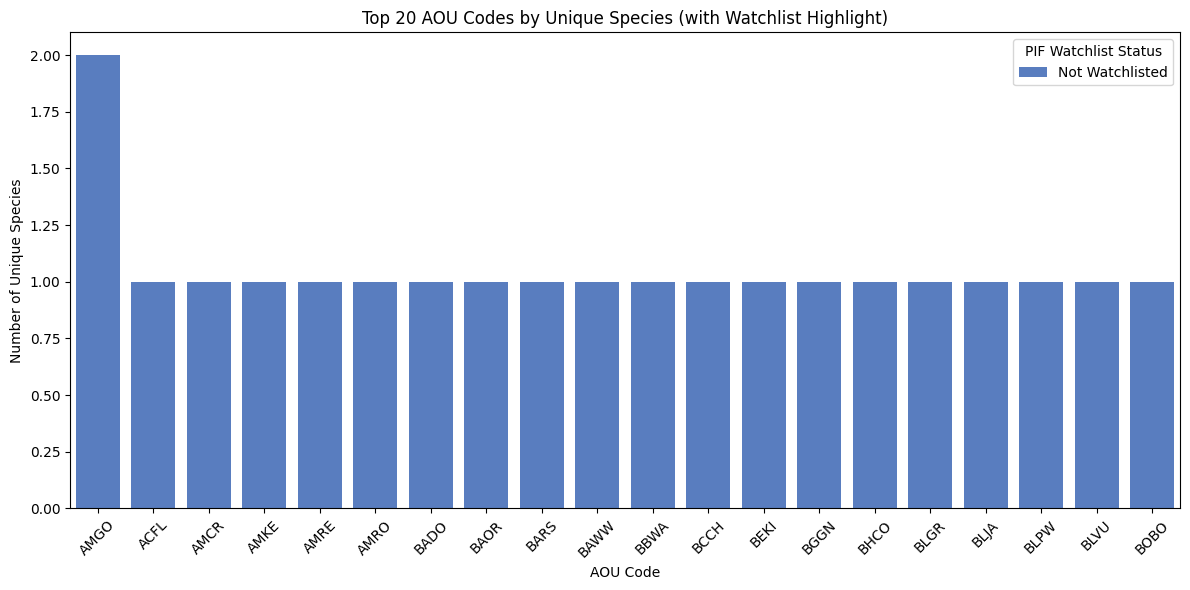

In [18]:
# AOU Code Patterns:

# Make sure AOU_Code is treated as string for grouping and plotting
full_table['AOU_Code'] = full_table['AOU_Code'].astype(str)

# Optional: remove NaNs or zeros if they aren't meaningful
full_table = full_table[full_table['AOU_Code'].notna() & (full_table['AOU_Code'] != '0')]

# Group data by AOU code
aou_summary = full_table.groupby('AOU_Code').agg({
    'Scientific_Name': pd.Series.nunique,
    'Common_Name': pd.Series.nunique,
    'PIF_Watchlist_Status': 'max',
    'Regional_Stewardship_Status': 'max'
}).reset_index()

# Rename for clarity
aou_summary.rename(columns={
    'Scientific_Name': 'Unique_Species',
    'Common_Name': 'Unique_Common_Names'
}, inplace=True)

# Optional: Create category for plotting
aou_summary['Watchlist'] = aou_summary['PIF_Watchlist_Status'].apply(
    lambda x: 'Watchlisted' if x == 1 else 'Not Watchlisted'
)

# ---- PLOT 1: Species count by AOU code ----
plt.figure(figsize=(12, 6))
sns.barplot(data=aou_summary.sort_values('Unique_Species', ascending=False).head(20),
            x='AOU_Code', y='Unique_Species', hue='Watchlist', dodge=False, palette='muted')
plt.title('Top 20 AOU Codes by Unique Species (with Watchlist Highlight)')
plt.xlabel('AOU Code')
plt.ylabel('Number of Unique Species')
plt.xticks(rotation=45)
plt.legend(title='PIF Watchlist Status')
plt.tight_layout()
plt.show()


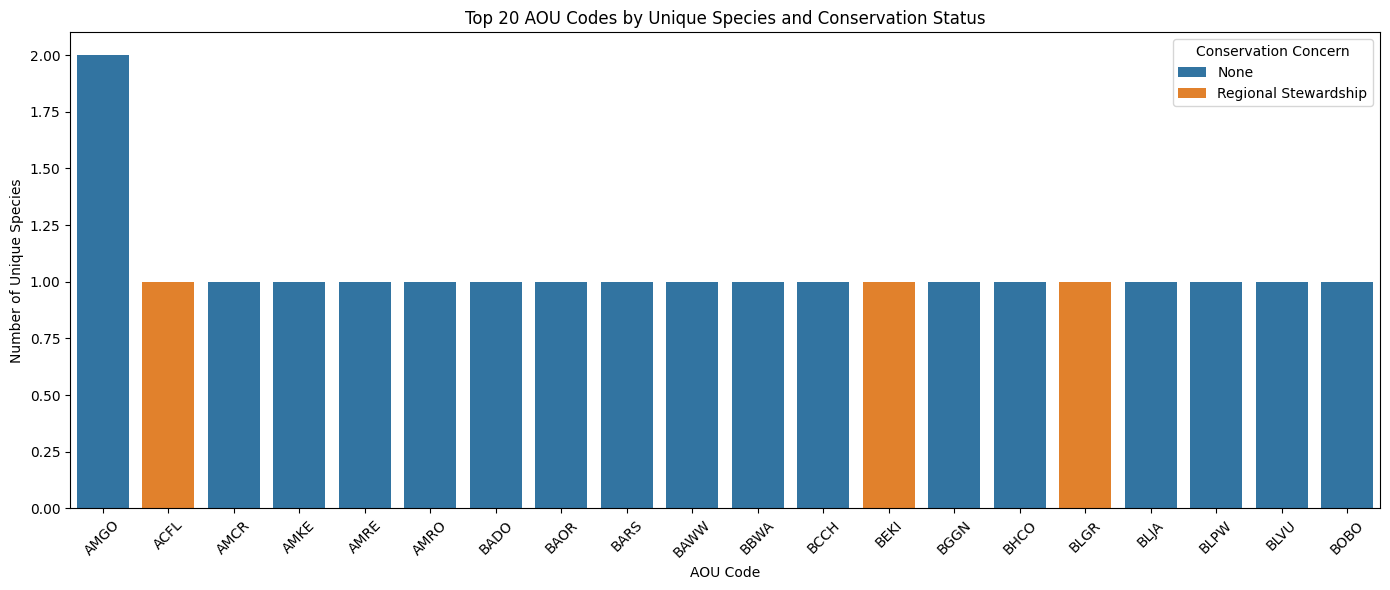

In [19]:

full_table['AOU_Code'] = full_table['AOU_Code'].astype(str)

# Filter out non-informative AOU codes
aou_data = full_table[full_table['AOU_Code'].notna() & (full_table['AOU_Code'] != '0')]

# Summarize by AOU_Code
aou_conservation_summary = aou_data.groupby('AOU_Code').agg({
    'Scientific_Name': pd.Series.nunique,
    'Common_Name': pd.Series.nunique,
    'PIF_Watchlist_Status': 'max',
    'Regional_Stewardship_Status': 'max'
}).reset_index()

# Define conservation concern labels
aou_conservation_summary['Conservation_Concern'] = aou_conservation_summary.apply(
    lambda row: 'Watchlist' if row['PIF_Watchlist_Status'] == 1 else (
        'Regional Stewardship' if row['Regional_Stewardship_Status'] == 1 else 'None'
    ),
    axis=1
)

# Plot top 20 AOU Codes by number of unique species
plt.figure(figsize=(14, 6))
top_aou = aou_conservation_summary.sort_values('Scientific_Name', ascending=False).head(20)
sns.barplot(data=top_aou, x='AOU_Code', y='Scientific_Name', hue='Conservation_Concern', dodge=False)
plt.title('Top 20 AOU Codes by Unique Species and Conservation Status')
plt.xlabel('AOU Code')
plt.ylabel('Number of Unique Species')
plt.xticks(rotation=45)
plt.legend(title='Conservation Concern')
plt.tight_layout()
plt.show()
